# UNet: Convolutional Networks for Biomedical Image Segmentation

### Imports

In [1]:
import os
import zipfile
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds

from utils import load_image_test, load_image_train, show_image_from_dataset

### Download the Dataset

In [2]:
dataset, info = tfds.load("oxford_iiit_pet:4.*.*", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.XOPTUT_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.XOPTUT_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [ ]:
print(dataset.keys())

dict_keys(['train', 'test'])


In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/home/cjung-mo/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label':

### Prepare the Dataset

In [3]:
def random_flip(input_image, input_mask):
    """
    random flip of input image and mask
    """
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask


def normalize(input_image, input_mask):
    """
    normalize input image pixel values to be from [0, 1]
    subtract 1 from the mask labels to have a range of [0, 2]
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask


@tf.function
def load_image_train(datapoint):
    """
    resize, normalize and flip the training data
    """
    input_image = tf.image.resize(datapoint["image"], (128, 128), method="nearest")
    input_mask = tf.image.resize(datapoint["segmentation_mask"], (128, 128), method="nearest")
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


def load_image_test(datapoint):
    """
    resize and normalized the test data
    """
    input_image = tf.image.resize(datapoint["image"], (128, 128), method="nearest")
    input_mask = tf.image.resize(datapoint["segmentation_mask"], (128, 128), method="nearest")
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [4]:
train = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset["test"].map(load_image_test)

In [5]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# shuffle and group the training set into batches
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = test.batch(BATCH_SIZE)

In [6]:
class_names = ["pet", "background", "outline"]

2025-03-15 17:32:20.015718: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-15 17:32:20.039937: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


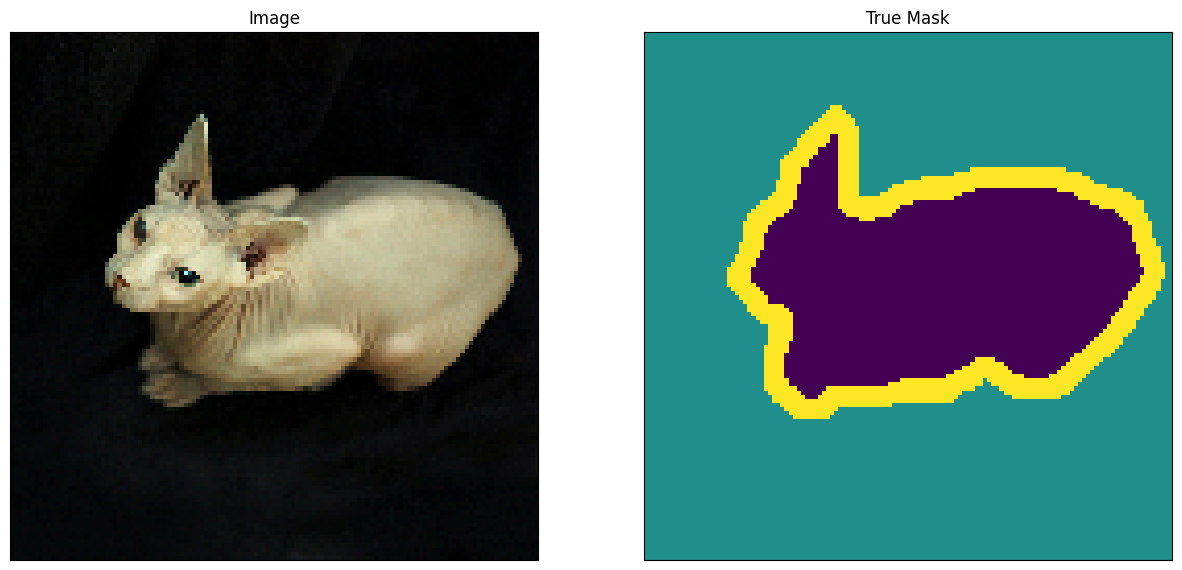

2025-03-15 17:32:20.428955: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


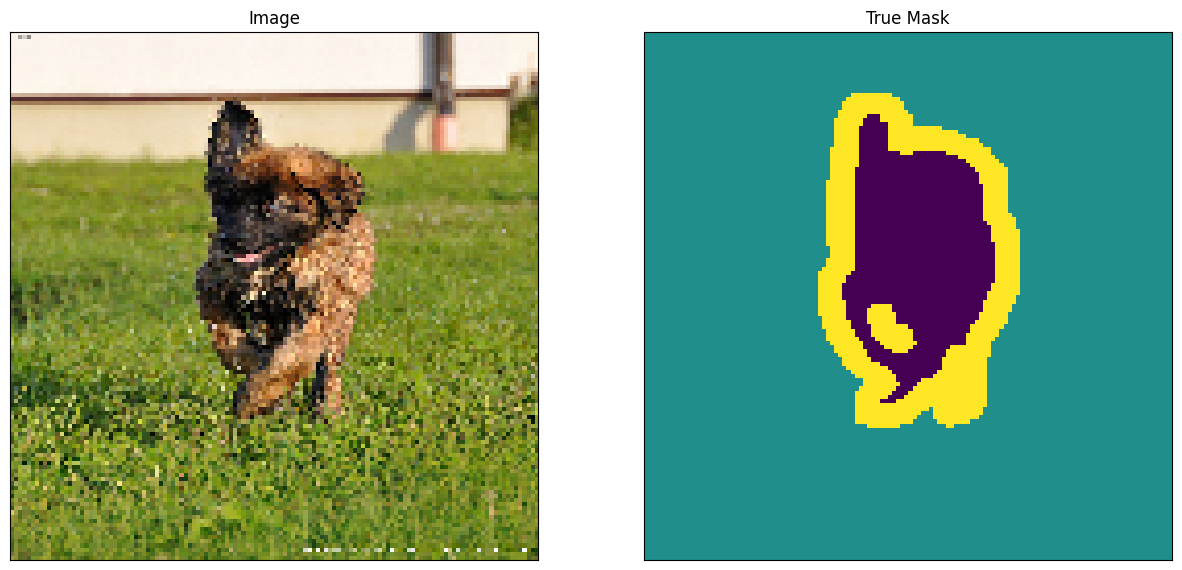

In [ ]:
# display an image from the train set
show_image_from_dataset(train)

# display an image from the test set
show_image_from_dataset(test)

## Define the Model


<div align="center">

  <img alt="UNet" src="https://github.com/jmcheon/paper_impl/blob/main/UNET_2015/assets/UNet.png?raw=1" width=800 height=400/>
  <br/>
  <figcaption>Figure 1: UNet Architecture</figcaption>

</div>

### Encoder


<div align="center">

  <img alt="UNet Encoder" src="https://github.com/jmcheon/paper_impl/blob/main/UNET_2015/assets/UNet_encoder.png?raw=1" width=800 height=400/>
  <br/>
  <figcaption>Figure 1: UNet Encoder</figcaption>

</div>

- `conv2d_block()`: to add two convolutional layers and ReLU activations
- `encoder_block()`: to add pooling and dropout to the conv2d blocks
- `encoder()`: to build the entire encoder. it returns the output of the last encoder block as well as the output of the previous conv blocks, which will be concatenated in the decoder block

#### conv2d_block()

In [7]:
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    """
    Add two convolutional layers with the parameters passed to it

    Args:
        input_tensor (tensor): input tensor
        n_filters (int): number of filters
        kernel_size (int): kernel size for the convolution

    Returns:
        tensor of output features(
    """
    # 1st layer
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.Conv2D(
            filters=n_filters,
            kernel_size=(kernel_size, kernel_size),
            kernel_initializer="he_normal",
            padding="same",
        )(x)
        x = tf.keras.layers.Activation("relu")(x)

    return x

#### encoder_block()

In [8]:
def encoder_block(inputs, n_filters=64, pool_size=(2, 2), dropout=0.3):
    """
    Add two convolutional blocks and then perform down sampling on output of convolutions

    Args:
        inputs (tensor): input tensor
        n_filters (int): number of filters
        pool_size (int, int): size of the pooling layer
        dropout (float): between 0 and 1. rate of dropout layer

    Returns:
        f: output features of the convolutional block
        p: maxpooled features with dropout
    """

    f = conv2d_block(inputs, n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(f)
    p = tf.keras.layers.Dropout(dropout)(p)

    return f, p

#### encoder()

In [9]:
def encoder(inputs):
    """
    This function defines the encoder and downsampling path

    Args:
        inputs (tensor): input tensor

    Returns:
        p4: the output maxpooled features of the last encoder block
        (f1, f2, f3, f4): the output features of all the encoder blocks
    """
    f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2, 2))
    f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2, 2))
    f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2, 2))
    f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2, 2))

    return p4, (f1, f2, f3, f4)

#### Bottleneck

In [10]:
def bottleneck(inputs):
    """
    This function defines the bottleneck convolutions to extract more features before upsampling layer
    """

    bottleneck = conv2d_block(input_tensor=inputs, n_filters=1024)

    return bottleneck

### Decoder


<div align="center">

  <img alt="UNet Decoder" src="https://github.com/jmcheon/paper_impl/blob/main/UNET_2015/assets/UNet_decoder.png?raw=1" width=800 height=400/>
  <br/>
  <figcaption>Figure 1: UNet Decoder</figcaption>

</div>

#### decoder_block()

In [11]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
    """
    Define the one decoder block in the UNet

    Args:
        inputs (tensor): batch of input features
        conv_output (tensor): features from an encoder block
        n_filters (int): number of filters
        kernel_size (int): kernel size
        strides (int): strides for deconvolution/upsampling
        dropout (float): between 0 and 1. rate of the dropout layer

    Returns:
        c (tensor): output features of the decoder block
    """

    u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides=strides, padding="same")(inputs)
    c = tf.keras.layers.concatenate([u, conv_output])
    c =  tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size=3)

    return c


#### decoder()

In [12]:
def decoder(inputs, convs, output_channels):
    """
    Define decoder of the UNet chanining together 4 decoder blocks

    Args:
        inputs (tensor): batch of input features
        convs (tuple): features from the encoder blocks
        output_channels (int): number of classes in the label map

    Returns:
        outputs (tensor): the pixel-wise label map of the image
    """

    f1, f2, f3, f4 = convs

    c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3, 3), strides=(2, 2))
    c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3, 3), strides=(2, 2))
    c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3, 3), strides=(2, 2))
    c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3, 3), strides=(2, 2))

    outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation="softmax")(c9)

    return outputs

### UNet

In [13]:
OUTPUT_CHANEELS = 3

def unet():
    """
    Define the UNet by connecting encoder, bottleneck and decoder
    """

    # specify the input shape
    inputs = tf.keras.layers.Input(shape=(128, 128, 3))

    encoder_output, convs = encoder(inputs)

    bottle_neck = bottleneck(encoder_output)

    outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANEELS)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="UNet")

    return model

In [14]:
model = unet()

model.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 128)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 32, 32, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ activation_5[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile the Model

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#### Train the Model

In [44]:
TRAIN_LENGTH = info.splits["train"].num_examples
EPOCHS = 5
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits["test"].num_examples // BATCH_SIZE // VAL_SUBSPLITS

In [45]:
checkpoint_path = "/checkpoints/unet.weights.h5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

model.load_weights("/checkpoints/unet.weights.h5")

Num GPUs Available:  1


In [46]:
history = model.fit(train_dataset,
          epochs=EPOCHS,
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_steps=VALIDATION_STEPS,
          validation_data=test_dataset,
          callbacks=[checkpoint_callback]
          )

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.8577 - loss: 0.3702
Epoch 1: val_loss improved from inf to 0.38947, saving model to /checkpoints/unet.weights.h5
57/57 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8577 - loss: 0.3702 - val_accuracy: 0.8525 - val_loss: 0.3895
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.8632 - loss: 0.3557
Epoch 2: val_loss did not improve from 0.38947
57/57 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8632 - loss: 0.3557 - val_accuracy: 0.8351 - val_loss: 0.4159
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.8671 - loss: 0.3444
Epoch 3: val_loss improved from 0.38947 to 0.38772, saving model to /checkpoints/unet.weights.h5
57/57 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8672 - loss: 0.3442 - val_accuracy: 0.8509 - val_loss: 0.3877
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.8698 - loss: 0.3381
Epoch 4: val_loss improved from 0.38772 to 0.36220, saving model to /checkpoin

### Evaluate the Model

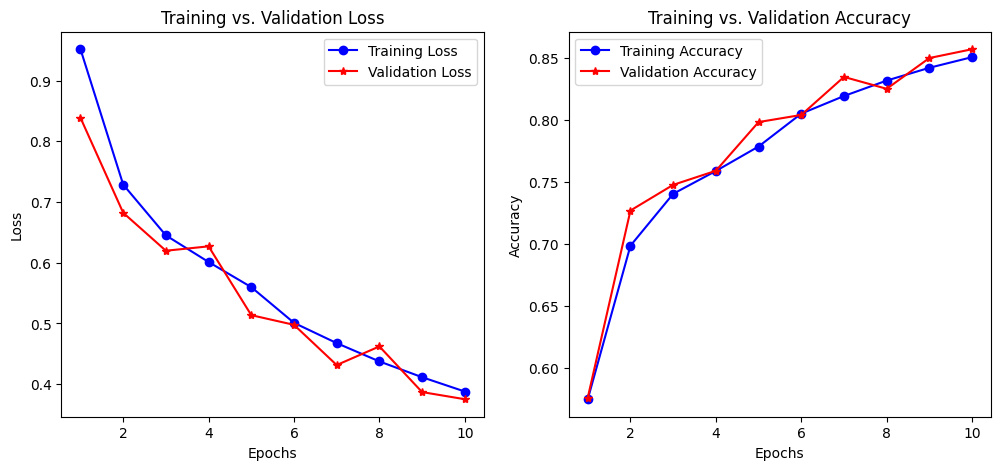

In [28]:
train_loss = model.history.history["loss"]
val_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
val_acc = model.history.history["val_accuracy"]

epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, "bo-", label="Training Loss")
plt.plot(epochs, val_loss, "r*-", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, "bo-", label="Training Accuracy")
plt.plot(epochs, val_acc, "r*-", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()

plt.show()

#### Test set

In [32]:
def get_test_image_and_annotation_arrays(dataset, test_size, batch_size):
    """
    Unpack the test dataset and return the input images and masks
    """

    ds = dataset.unbatch()

    images = []
    y_true_segments = []

    for image, annotation in ds.take(test_size):
        images.append(image.numpy())
        y_true_segments.append(annotation.numpy())

    images = np.array(images)
    y_true_segments = np.array(y_true_segments)

    valid_size = test_size - (test_size % batch_size)

    return images[:valid_size], y_true_segments[:valid_size]


def create_mask(pred_mask):
    """
    Create the segmentation mask by getting the channel with the highest probability
    """

    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
    """
    Feed an image to a model and returns predicted mask
    """

    image = np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)

    return pred_mask

In [33]:
# Setup the ground truth and predictions.

# get the ground truth from the test set
y_true_images, y_true_segments = get_test_image_and_annotation_arrays(test_dataset, info.splits["test"].num_examples, BATCH_SIZE)

# get the predictions from the test set
y_pred_segments = []

# feed the test set to th emodel to get the predicted masks
results = model.predict(test_dataset, steps=info.splits['test'].num_examples // BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 335ms/step


#### Compute Metrics

In [30]:
def compute_metrics(y_true, y_pred):
    """
    Compute IOU and Dice score
    Args:
        y_true (tensor): ground truth segmentation masks/label maps
        y_pred (tensor): predicted segmentation masks/label maps

    Returns:
        tuple of floats: IOU and Dice score
    """

    class_wise_iou = []
    class_wise_dice_score = []

    smoothing_factor = 0.00001

    for i in range(1, len(class_names)):
        intersection = np.sum((y_pred == i) * (y_true == i))
        y_true_area = np.sum(y_true == i)
        y_pred_area = np.sum(y_pred == i)
        combined_area = y_true_area + y_pred_area

        iou = (intersection + smoothing_factor) / (combined_area - intersection + smoothing_factor)
        class_wise_iou.append(iou)

        dice_score = 2 * ((intersection + smoothing_factor) / (combined_area + smoothing_factor))
        class_wise_dice_score.append(dice_score)

    return class_wise_iou, class_wise_dice_score

In [42]:
def display_with_metrics(display_list, iou_list, dice_score_list):
    """
    display a list of images/masks and overlays a list of IOU and dice score
    """

    metrics_by_id = [
        (idx, iou, dice_score)
        for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list))
        if iou > 0.0
    ]
    metrics_by_id.sort(key=lambda x: x[1], reverse=True)

    display_string_list = [
        f"{class_names[idx]} IOU: {iou} Dice Score: {dice_score}"
        for idx, iou, dice_score in metrics_by_id
    ]
    display_string = "\n\n".join(display_string_list)

    display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string)


def display(display_list, titles=[], display_string=None):
    """
    display a list of images/masks
    """
    plt.figure(figsize=(15, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])
        if display_string and i == 1:
            plt.xlabel(display_string, fontsize=12)
        img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
        plt.imshow(img_arr)

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


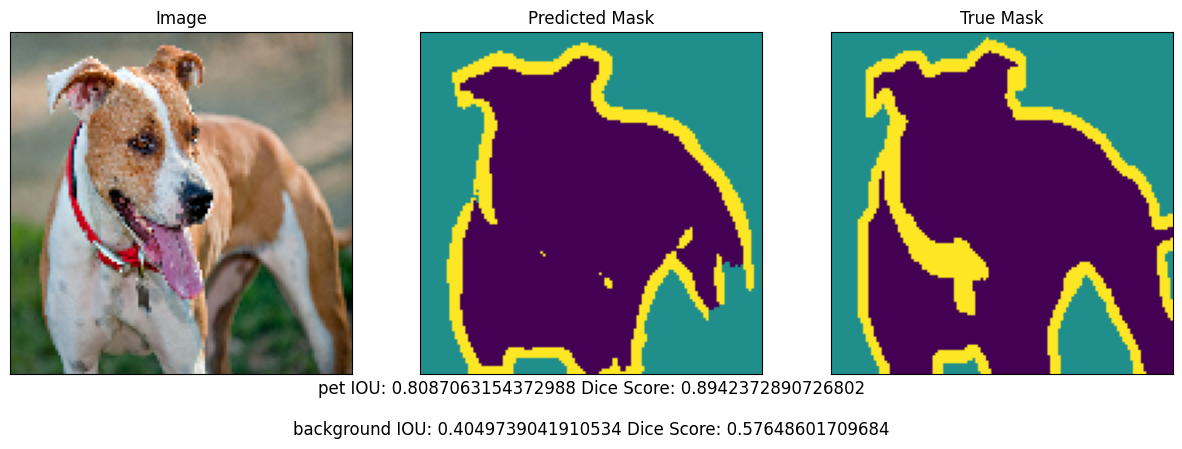

In [43]:
# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 3646

# Get the prediction mask
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])

# Compute the class wise metrics
iou, dice_score = compute_metrics(y_true_segments[integer_slider], y_pred_mask)

# Overlay the metrics with the images
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)

#### Display class-wise Metrics

In [38]:
cls_wise_iou, cls_wise_dice_score = compute_metrics(y_true_segments, results)

In [39]:
for idx, iou in enumerate(cls_wise_iou):
    spaces = ' ' * (13-len(class_names[idx]) + 2)
    print(f"{class_names[idx]}{spaces}{iou}")

pet            0.8467053159945835
background     0.36664659066194183


In [40]:
# print the dice score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (13-len(class_names[idx]) + 2)
  print(f"{class_names[idx]}{spaces}{dice_score}")

pet            0.9169901755967947
background     0.5365638683292091
